In [1]:
from __future__ import division, print_function

In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline
# %pylab notebook
# %load_ext wurlitzer


Populating the interactive namespace from numpy and matplotlib


In [3]:
import time
import numpy as np
from collections import namedtuple


from director import viewerclient as vc
from irispy import Polyhedron
import boxatlas.boxatlas as box
from boxatlas.contactstabilization import BoxAtlasContactStabilization

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [4]:
vis = vc.Visualizer()

In [12]:
surfaces = [
    box.Surface(Polyhedron.fromBounds([1.2, 0], [1.2, 2]),
            Polyhedron(np.array([[1, -1], [1, 1]]), np.array([0, 0]))),
    box.Surface(Polyhedron.fromBounds([-2, 0], [2, 0]), 
            Polyhedron(np.array([[-2, -1], [2, -1]]), np.array([0, 0]))),
    box.Surface(Polyhedron.fromBounds([-2, 0], [2, 0]), 
            Polyhedron(np.array([[-2, -1], [2, -1]]), np.array([0, 0]))),
    box.Surface(Polyhedron.fromBounds([-1.2, 0], [-1.2, 2]),
            Polyhedron(np.array([[-1, -1], [-1, 1]]), np.array([0, 0]))),
]

limb_idx_map = dict()
limb_idx_map["right_arm"] = 0
limb_idx_map["right_leg"] = 1
limb_idx_map["left_leg"] = 2
limb_idx_map["left_arm"] = 3

limb_velocity_limits = [4]*4

env = box.Environment(surfaces, Polyhedron.fromBounds([-1.2, 0], [1.2, 2]))
atlas = box.BoxAtlas()
atlas.limb_velocity_limits = limb_velocity_limits

large_leg_limb_bound = Polyhedron.fromBounds([-2.0, -1.0], [2.0, -0.5])
leg_names = ["left_leg", "right_leg"]
for limb in leg_names:
    idx = limb_idx_map[limb]
    atlas.limb_bounds[idx] = large_leg_limb_bound
    

params = BoxAtlasContactStabilization.get_optimization_parameters()
params['costs']['contact_force'] = 2e-2
params['costs']['arm_final_position'] = 1e2
params['costs']['leg_final_position'] = 1e2

SolutionData = namedtuple("SolutionData", ["opt" ,"states", "inputs", "contact_indicator", "ts"])


def add_persistent_contact_constraints(opt, contact_name):
    """
    :param opt  BoxAtlasContactStabilization
    """
    idx = opt.robot.limb_idx_map[contact_name]
    contact = opt.vars.contact[idx]
    
    for var in contact.at_all_breaks():
        opt.prog.AddLinearConstraint(var[0] == 1)
        
def add_feet_always_in_contact_constraints(opt):
    contact_names = ["left_leg", "right_leg"]
    for contact_name in contact_names:
        add_persistent_contact_constraints(opt, contact_name)


def solveContactStabilization(opt=None, initial_state=None):
    if opt is None:
        if initial_state is None:
            initial_state = makeDefaultInitialState()            
        opt = BoxAtlasContactStabilization(initial_state, env, params=params)
        
    states, inputs, contact_indicator = opt.solve()
    ts = states.components[0].breaks
    
#     solnData = namedtuple("SolutionData", ["opt" ,"states", "inputs", "contact_indicator", "ts"])
#     solnData.opt = opt
#     solnData.states = states
#     solnData.inputs = inputs
#     solnData.contact_indicator = contact_indicator
#     solnData.ts = ts
    
    solnData = SolutionData(opt=opt, states=states, inputs=inputs,
                            contact_indicator=contact_indicator,
                           ts = ts)
    return solnData

        
def makeDefaultInitialState():
    initial_state = box.BoxAtlasState(atlas)
    initial_state.qcom = np.array([0, 1])
    initial_state.vcom = np.array([-0, 0.])
    initial_state.qlimb = map(np.array, [[0.75, 1], [0.25, 0], [-0.25, 0], [-0.75, 1]])
    return initial_state


def makeDefaultOptimizationProblem(initial_state=None):
    if initial_state is None:
        initial_state = makeDefaultInitialState()
    opt = BoxAtlasContactStabilization(initial_state, env, params=params)
    return opt
    
def testInitialVCOM(vcom_x_list):
    solnDataList = []
    
    for vcom_x in vcom_x_list:
        initial_state = makeDefaultInitialState()
        initial_state.vcom = np.array([vcom_x, 0])
        solnDataList.append(solveContactStabilization(initial_state))
        
    return solnDataList

def getContactIndicatorVariable(solnData, contact_name="left_arm"):
    idx = limb_idx_map[contact_name]
    ts = solnData.ts
    return [solnData.contact_indicator[idx](t) for t in ts[:-1]]

def plotContactIndicator(solnData):
    contact_indicator_left_arm = getContactIndicatorVariable(solnData, contact_name="left_arm")
    ts = solnData.ts
    vcom_x = solnData.states(0).vcom[0]
    label = 'initial com vel = ' + str(vcom_x)
    plt.plot(ts[:-1], contact_indicator_left_arm, label=label, alpha=1.0)
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('contact indicator')
    plt.show()
    
def arrayFromStateTrajectory(states, fieldname):
    ts = states.components[0].breaks
    val_list = []
    for t in ts[:-1]:
        boxAtlasState = states(t)
        val_list.append(getattr(boxAtlasState, fieldname))
        
    val_array = np.array(val_list)
    return val_array

def plotContactIndicatorWidget(idx, solnDataList):
    plotContactIndicator(solnDataList[idx])
    

def solveAlongTrajectory(solnData):
    solnDataList = []
    solnDataList.append(solnData)
    
    for t in solnData.ts[1:-1]:
        boxAtlasState = solnData.states(t)
        solnDataList.append(solveContactStabilization(initial_state=boxAtlasState))
    
    return solnDataList

None

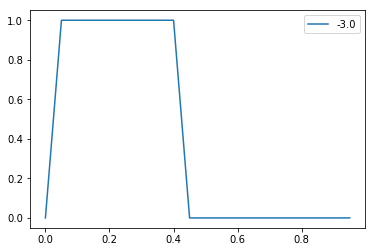

In [6]:
# solve a single problem and visualize the solution
initial_state = box.BoxAtlasState(atlas)
initial_state.qcom = np.array([0, 1])
initial_state.vcom = np.array([-3, 0.])
initial_state.qlimb = map(np.array, [[0.99, 1], [0.25, 0], [-0.25, 0], [-0.75, 1]])

solnData = solveContactStabilization(initial_state=initial_state)
# visualizeContactStabilizationPlan(solnData)
box.planPlayback(vis, solnData, slider=True)
plotContactIndicator(solnData)

In [9]:
# WARNING: This could take a while to run

# Solve a sequence of problems for different initial velocities
vcom_x_list = np.arange(-1.0,-4.01, -0.25)
# vcom_x_list = [-2.0, -1.0]
solnDataList = []
for vcom_x in vcom_x_list:
    initial_state = makeDefaultInitialState()
    initial_state.vcom = np.array([vcom_x, 0])
    
    opt = BoxAtlasContactStabilization(initial_state, env, params=params)
    add_feet_always_in_contact_constraints(opt)
    solnDataList.append(solveContactStabilization(opt=opt))
    

    
# for each of those solve along their resulting trajectories as well
# solnDataAlongTrajectory = []
# for solnData in solnDataList:
#     solnDataAlongTrajectory.append(solveAlongTrajectory(solnData))


SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound
SolutionResult.kSolutionFound


In [ ]:
# try some simple plotting


qcom_x = []
vcom_x = []
num_timesteps_in_contact = []

for solnDataList in solnDataAlongTrajectory:
    for solnData in solnDataList:
        qcom_x.append(solnData.states(0).qcom[0])
        vcom_x.append(solnData.states(0).vcom[0])
        contact_indicator = getContactIndicatorVariable(solnData, "left_arm")
        num_timesteps_in_contact.append(sum(contact_indicator))
        
        
qcom_x = np.array(qcom_x)
vcom_x = np.array(vcom_x)
num_timesteps_in_contact = np.array(num_timesteps_in_contact)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.scatter(qcom_x, vcom_x, num_timesteps_in_contact, c=num_timesteps_in_contact,
                  cmap=cm.coolwarm, antialiased=False)

# surf = ax.plot_wireframe(qcom_x, vcom_x, num_timesteps_in_contact,
#                   cmap=cm.coolwarm, antialiased=False)
ax.set_xlabel("com x position")
ax.set_ylabel("com x velocity")

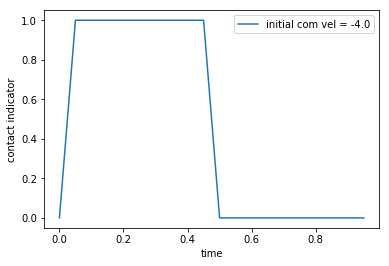

None

In [13]:
slider = widgets.IntSlider(min=0,max=len(solnDataList)-1,step=1,value=0)
interact(plotContactIndicatorWidget, idx=slider, solnDataList=fixed(solnDataList))

# plot the trajectory of the com for each initial condition specified above
for solnData in solnDataList:
    states = solnData.states
    qcom_array = arrayFromStateTrajectory(states,'qcom')
    vcom_array = arrayFromStateTrajectory(states, 'vcom')
    plt.plot(qcom_array[:,0], vcom_array[:,0])
    
plt.xlabel('com x position')
plt.ylabel('com x velocity')
plt.show()



In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

for solnData in solnDataList:
    contact_indicator_left_arm = getContactIndicatorVariable(solnData, contact_name="left_arm")
    ts = solnData.ts
    vcom_x = solnData.states(0).vcom[0]
    label = 'initial com vel = ' + str(vcom_x)
    ax.plot(ts[:-1], contact_indicator_left_arm, label=label, alpha=1.0)
#     ax.legend(loc='best')
#     plt.xlabel('time')
#     plt.ylabel('contact indicator')
#     plt.show()
    fig.show()
    time.sleep(0.25)
    fig.clf()

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [ ]:
solnData = solnDataList[6]
vcom_x = solnData.states(0).vcom[0]
box.planPlayback(vis, solnData, slider=True)
print("com initial x velocity = ", vcom_x)

In [ ]:
a = [1,2,3]
sum(a)

In [31]:
# Solve an MIQP for each state along the initial solution
initial_state = makeDefaultInitialState()
initial_state.vcom = np.array([-4.0, 0.])
opt = BoxAtlasContactStabilization(initial_state, env, params=params)
solnData = solveContactStabilization(opt=opt)

solnDataAlongTrajectory = []
solnDataAlongTrajectory.append(solnData)

box.planPlayback(vis, solnData, slider=True)


for t in solnData.ts[:-1]:
    print("solving program for t = ", t)
    boxAtlasState = solnData.states(t)
    solnDataAlongTrajectory.append(solveContactStabilization(initial_state=boxAtlasState))

None

solving program for t =  0.0
SolutionResult.kSolutionFound
solving program for t =  0.05
SolutionResult.kSolutionFound
solving program for t =  0.1
SolutionResult.kSolutionFound
solving program for t =  0.15
SolutionResult.kSolutionFound
solving program for t =  0.2
SolutionResult.kSolutionFound
solving program for t =  0.25
SolutionResult.kSolutionFound
solving program for t =  0.3
SolutionResult.kSolutionFound
solving program for t =  0.35
SolutionResult.kSolutionFound
solving program for t =  0.4
SolutionResult.kSolutionFound
solving program for t =  0.45
SolutionResult.kSolutionFound
solving program for t =  0.5
SolutionResult.kSolutionFound
solving program for t =  0.55
SolutionResult.kSolutionFound
solving program for t =  0.6
SolutionResult.kSolutionFound
solving program for t =  0.65
SolutionResult.kSolutionFound
solving program for t =  0.7
SolutionResult.kSolutionFound
solving program for t =  0.75
SolutionResult.kSolutionFound
solving program for t =  0.8
SolutionResult.kSol

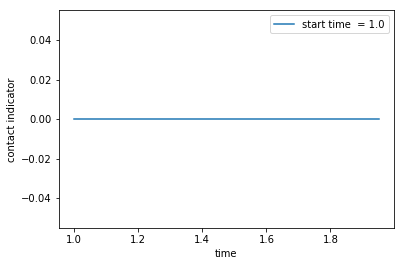

None

In [37]:
# plot switching sequence as we move along trajectory

ts_orig = solnData.ts
def customPlotting(idx):
    solnData = solnDataAlongTrajectory[idx]
    t = ts_orig[idx]
    contact_indicator_left_arm = getContactIndicatorVariable(solnData, contact_name="left_arm")
    ts = solnData.ts
    vcom_x = solnData.states(0).vcom[0]
    label = 'start time  = ' + str(t)
    plt.plot(t + ts[:-1], contact_indicator_left_arm, label=label, alpha=1.0)
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('contact indicator')
    plt.show()
    
slider = widgets.IntSlider(min=0,max=len(solnDataAlongTrajectory)-1,step=1,value=0)
interact(customPlotting, idx=slider)

In [ ]:
idx = 5
box.planPlayback(vis, solnDataAlongTrajectory[idx], slider=True)


In [26]:
t = 1.22222222
test = str(round(t,2))
print(test)

1.22
